# Stock Prediction/Tracker with Pytorch
Track and predict [GCL.TO](https://ca.finance.yahoo.com/quote/CGL.TO?p=CGL.TO&.tsrc=fin-srch)
## Resources used in this project
- [Pytorch LSTM model Youtube](https://www.youtube.com/watch?v=CbTU92pbDKw)
- [Pytorch LSTM documentation](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
- [Pytorch LSTM Youtube 2](https://www.youtube.com/watch?v=J_ksCv_r_rU)
- [LSTM Model](https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/)
- [LSTM Explaination](https://cnvrg.io/pytorch-lstm/)
- [code_lstm](https://colab.research.google.com/drive/1CBIdPxHn_W2ARx4VozRLIptBrXk7ZBoM?usp=sharing#scrollTo=-Xon2PHWno7t)

In [1]:
import yfinance as yf
GCL = yf.Ticker("CGL.TO")

In [2]:
gcl_df = GCL.history(interval="1d",period="3y")
gcl_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2021-02-22 00:00:00-05:00,14.850000,14.960000,14.85,14.92,80300,0.0,0.0,0.0
2021-02-23 00:00:00-05:00,14.940000,14.960000,14.82,14.91,37100,0.0,0.0,0.0
2021-02-24 00:00:00-05:00,14.800000,14.870000,14.75,14.85,55200,0.0,0.0,0.0
2021-02-25 00:00:00-05:00,14.750000,14.770000,14.61,14.61,137800,0.0,0.0,0.0
2021-02-26 00:00:00-05:00,14.550000,14.550000,14.13,14.28,563800,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2024-02-13 00:00:00-05:00,16.040001,16.040001,15.92,15.93,23000,0.0,0.0,0.0
2024-02-14 00:00:00-05:00,15.910000,15.950000,15.88,15.92,34200,0.0,0.0,0.0
2024-02-15 00:00:00-05:00,16.000000,16.030001,16.00,16.01,4400,0.0,0.0,0.0


In [3]:
insitutional_holders_gcl = GCL.get_institutional_holders()
print(insitutional_holders_gcl)

                        0           1
0              Net Assets     915.98M
1                     NAV       15.98
2          PE Ratio (TTM)         NaN
3                   Yield       0.00%
4  YTD Daily Total Return      -2.61%
5       Beta (5Y Monthly)        0.00
6     Expense Ratio (net)       0.00%
7          Inception Date  2011-03-31


In [4]:
gcl_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 752 entries, 2021-02-22 00:00:00-05:00 to 2024-02-20 00:00:00-05:00
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           752 non-null    float64
 1   High           752 non-null    float64
 2   Low            752 non-null    float64
 3   Close          752 non-null    float64
 4   Volume         752 non-null    int64  
 5   Dividends      752 non-null    float64
 6   Stock Splits   752 non-null    float64
 7   Capital Gains  752 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 52.9 KB


In [5]:
import plotly.graph_objects as go
from plotly.offline import plot
from IPython.display import display, HTML
gcl_plot = go.Figure(go.Ohlc(x=gcl_df.index,
                  open=gcl_df["Open"]
                  ,close=gcl_df["Close"],
                  low=gcl_df["Low"],
                  high=gcl_df["High"]))


gcl_plot.update_layout(title_text='GCL chart', xaxis_title='Date', yaxis_title='Price')

display(gcl_plot)

In [6]:
closing_gcl = gcl_df[["Close"]]
closing_gcl

,Close
Date,
2021-02-22 00:00:00-05:00,14.92
2021-02-23 00:00:00-05:00,14.91
2021-02-24 00:00:00-05:00,14.85
2021-02-25 00:00:00-05:00,14.61
2021-02-26 00:00:00-05:00,14.28
...,...
2024-02-13 00:00:00-05:00,15.93
2024-02-14 00:00:00-05:00,15.92
2024-02-15 00:00:00-05:00,16.01


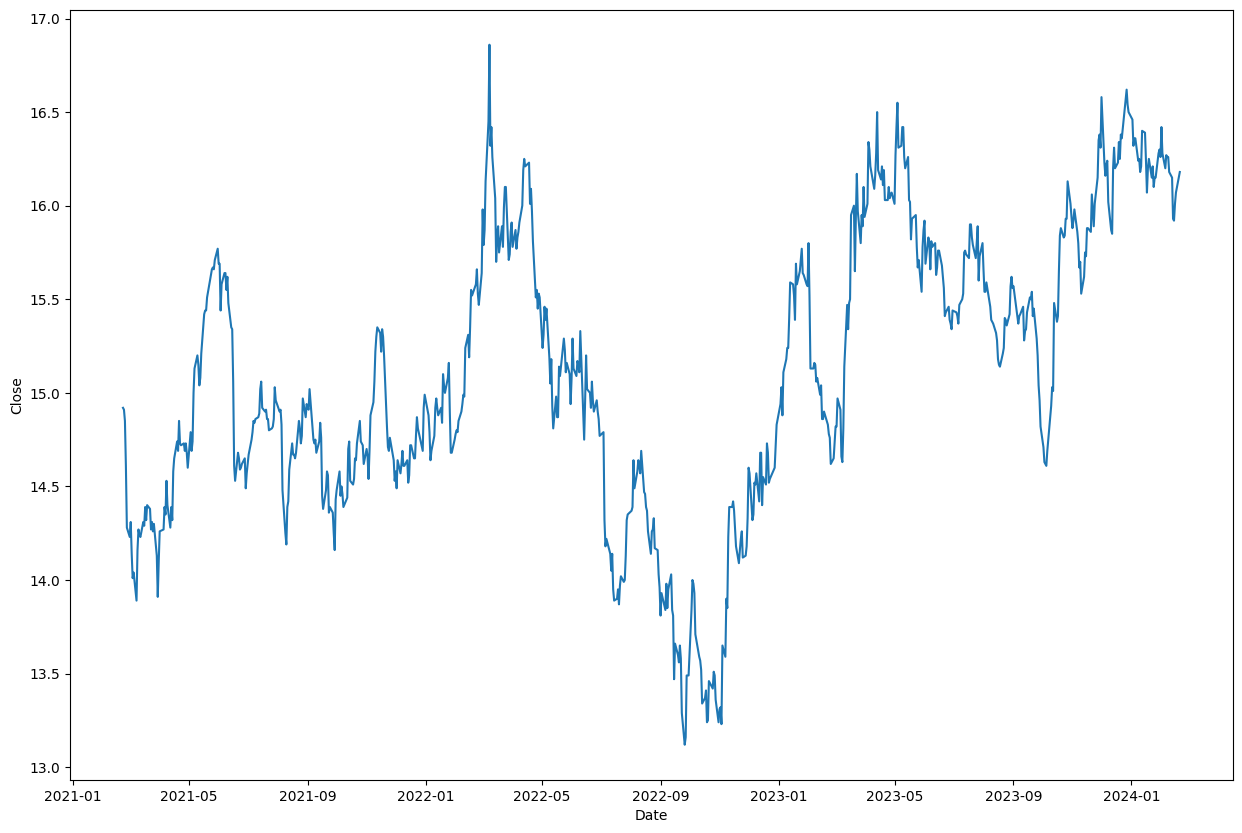

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
gcl_closing_plot = sns.lineplot(data=closing_gcl, y="Close", x=closing_gcl.index)   ##.set_ylim(0,18.0)
plt.show()

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

In [9]:
from copy import deepcopy as dc

def df_lstm(df, n_steps):
    df_pre = dc(df)

    df_pre.set_index(df.index, inplace=True)

    for i in range(1, n_steps + 1):
        df_pre[f'Current Day-{i}'] = df_pre["Close"].shift(i)

    df_pre.dropna(inplace=True)

    return df_pre



lookback = 10   #show data from previous 10 business days
modified_df = df_lstm(closing_gcl, lookback)
modified_df

,Close,Current Day-1,Current Day-2,Current Day-3,Current Day-4,Current Day-5,Current Day-6,Current Day-7,Current Day-8,Current Day-9,Current Day-10
Date,,,,,,,,,,,
2021-03-08 00:00:00-05:00,13.89,14.04,14.01,14.14,14.31,14.23,14.280000,14.610000,14.850000,14.910000,14.920000
2021-03-09 00:00:00-05:00,14.16,13.89,14.04,14.01,14.14,14.31,14.230000,14.280000,14.610000,14.850000,14.910000
2021-03-10 00:00:00-05:00,14.27,14.16,13.89,14.04,14.01,14.14,14.310000,14.230000,14.280000,14.610000,14.850000
2021-03-11 00:00:00-05:00,14.24,14.27,14.16,13.89,14.04,14.01,14.140000,14.310000,14.230000,14.280000,14.610000
2021-03-12 00:00:00-05:00,14.23,14.24,14.27,14.16,13.89,14.04,14.010000,14.140000,14.310000,14.230000,14.280000
...,...,...,...,...,...,...,...,...,...,...,...
2024-02-13 00:00:00-05:00,15.93,16.15,16.18,16.26,16.26,16.27,16.200001,16.280001,16.420000,16.260000,16.299999
2024-02-14 00:00:00-05:00,15.92,15.93,16.15,16.18,16.26,16.26,16.270000,16.200001,16.280001,16.420000,16.260000
2024-02-15 00:00:00-05:00,16.01,15.92,15.93,16.15,16.18,16.26,16.260000,16.270000,16.200001,16.280001,16.420000


In [10]:
from sklearn.preprocessing import MinMaxScaler

np_modified_df = modified_df.to_numpy()
print(np_modified_df[:, 1:])
print("\n")

scaler = MinMaxScaler(feature_range=(0,1))
rescaled_prices = scaler.fit_transform(np_modified_df)  #This is the data used to train our model.
print(rescaled_prices)


[[14.03999996 14.01000023 14.14000034 ... 14.85000038 14.90999985
  14.92000008]
 [13.89000034 14.03999996 14.01000023 ... 14.60999966 14.85000038
  14.90999985]
 [14.15999985 13.89000034 14.03999996 ... 14.27999973 14.60999966
  14.85000038]
 ...
 [15.92000008 15.93000031 16.14999962 ... 16.20000076 16.28000069
  16.42000008]
 [16.01000023 15.92000008 15.93000031 ... 16.27000046 16.20000076
  16.28000069]
 [16.06999969 16.01000023 15.92000008 ... 16.26000023 16.27000046
  16.20000076]]


[[0.20588244 0.24598928 0.23796796 ... 0.46256689 0.47860952 0.48128338]
 [0.2780748  0.20588244 0.24598928 ... 0.39839558 0.46256689 0.47860952]
 [0.30748672 0.2780748  0.20588244 ... 0.31016033 0.39839558 0.46256689]
 ...
 [0.77272721 0.74866301 0.75133686 ... 0.82352949 0.84491984 0.88235282]
 [0.78876985 0.77272721 0.74866301 ... 0.84224598 0.82352949 0.84491984]
 [0.81818177 0.78876985 0.77272721 ... 0.83957212 0.84224598 0.82352949]]


In [11]:
import numpy as np

X = dc(np.flip(rescaled_prices[: ,1:], axis=1))
Y = rescaled_prices[:, 0]

print(X.shape)
print(Y.shape)



(742, 10)
(742,)


In [12]:
train_ratio = 0.95
split_index = int(len(X) * train_ratio)

X_train = X[:split_index].reshape((-1, lookback, 1))
X_test = X[split_index:].reshape((-1, lookback, 1))

Y_train = Y[:split_index].reshape((-1,1))
Y_test = Y[split_index:].reshape((-1,1))

print(X_train.shape)
print(Y_train.shape)


print(X_test.shape)
print(Y_test.shape)

(704, 10, 1)
(704, 1)
(38, 10, 1)
(38, 1)


In [13]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
Y_train = torch.tensor(Y_train).float()
Y_test = torch.tensor(Y_test).float()


X_test.shape

torch.Size([38, 10, 1])

In [14]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.Y[i]
    
train_data = TimeSeriesDataset(X_train, Y_train)
test_data = TimeSeriesDataset(X_test, Y_test)


In [15]:
from torch.utils.data import DataLoader
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)

In [16]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, X):
        hidden_size = torch.zeros(self.num_layers, X.size(0), self.hidden_size)
        cell_states = torch.zeros(self.num_layers, X.size(0), self.hidden_size)
        out, _ = self.lstm(X, (hidden_size, cell_states))
        out = self.dropout(out)
        out = self.output_layer(out[:, -1, :])  #reshape tensor
        return out

In [17]:
input_size = 1  
hidden_size = 20  
num_layers = 2  
dropout_rate = 0.2
model = LSTM(input_size, hidden_size, num_layers, dropout_rate)
model

LSTM(
  (lstm): LSTM(1, 20, num_layers=2, batch_first=True)
  (output_layer): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [18]:
# Define your optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
num_epochs = 1000  # Adjust the number of epochs as needed

for epoch in range(num_epochs):
    # Forward pass
    outputs = model.forward(X_train)

    # Zero the gradients
    optimizer.zero_grad()

    # Calculate the loss
    loss = criterion(outputs, Y_train)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Print loss every 100 epochs
    if epoch % 100 == 0:
        print("Epoch: %d, Loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, Loss: 0.36756
Epoch: 100, Loss: 0.02473
Epoch: 200, Loss: 0.00956
Epoch: 300, Loss: 0.00818
Epoch: 400, Loss: 0.00797
Epoch: 500, Loss: 0.00739
Epoch: 600, Loss: 0.00645
Epoch: 700, Loss: 0.00584
Epoch: 800, Loss: 0.00588
Epoch: 900, Loss: 0.00543


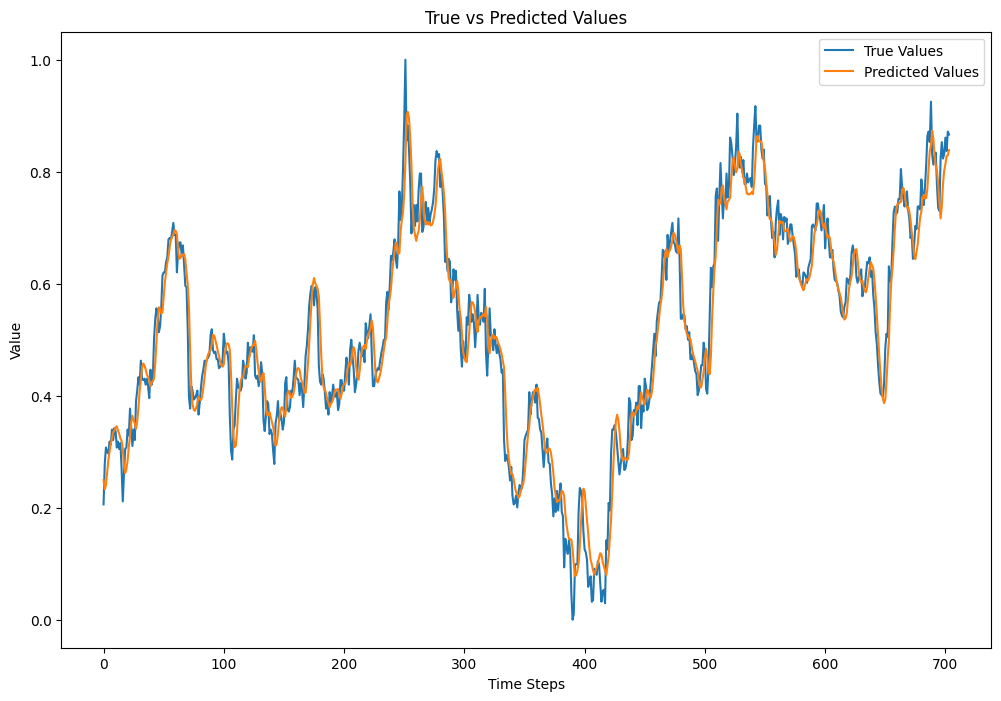

In [19]:
model.eval()
with torch.no_grad():
    predicted = model(X_train)

Y_train_np = Y_train.numpy()
predicted_np = predicted.numpy()

plt.figure(figsize=(12, 8))
plt.plot(Y_train_np, label='True Values')
plt.plot(predicted_np, label='Predicted Values')
plt.title('True vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

#X_train vs Y_train

In [20]:
trained_prediction = predicted_np.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = trained_prediction
dummies = scaler.inverse_transform(dummies)

trained_prediction = dc(dummies[:, 0])
trained_prediction

array([14.05268029, 13.99143949, 14.02014419, 14.10656982, 14.18674049,
       14.24047637, 14.29507885, 14.33006447, 14.37271056, 14.38360975,
       14.40421549, 14.41172148, 14.38445618, 14.36248984, 14.3304645 ,
       14.31541229, 14.26237438, 14.14790658, 14.0988321 , 14.12687127,
       14.1845796 , 14.27609208, 14.3449097 , 14.44215973, 14.48164758,
       14.45168895, 14.43184827, 14.39412763, 14.44403951, 14.53532605,
       14.64603395, 14.71894029, 14.80501984, 14.83140336, 14.81819516,
       14.79331668, 14.75839861, 14.73932322, 14.71937532, 14.67765469,
       14.70420229, 14.71201535, 14.73302168, 14.83538831, 14.98254319,
       15.12732809, 15.20651022, 15.19535635, 15.16405149, 15.17562936,
       15.27439068, 15.37367899, 15.44096537, 15.501141  , 15.54526561,
       15.61005951, 15.65817486, 15.67534383, 15.69223235, 15.72297188,
       15.71665629, 15.69706663, 15.58264597, 15.53026323, 15.5351247 ,
       15.56045593, 15.55176912, 15.56236502, 15.52370265, 15.43

In [21]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = Y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_Y_train = dc(dummies[:, 0])
new_Y_train

array([13.89000032, 14.15999984, 14.27000041, 14.23999976, 14.22999951,
       14.31000043, 14.28999992, 14.39000035, 14.31999968, 14.3999996 ,
       14.3800001 , 14.27000041, 14.31000043, 14.26000027, 14.30000018,
       14.13000008, 13.90999983, 14.10000043, 14.26000027, 14.27000041,
       14.39000035, 14.35000033, 14.52999968, 14.3999996 , 14.27999978,
       14.39000035, 14.31999968, 14.57999995, 14.64999961, 14.73999979,
       14.68999963, 14.85000036, 14.72999953, 14.72000028, 14.72999953,
       14.68999963, 14.72999953, 14.68000027, 14.60000035, 14.78999995,
       14.68999963, 14.73999979, 15.00000006, 15.13000002, 15.1999998 ,
       15.14999964, 15.03999996, 15.07999986, 15.21000005, 15.42000005,
       15.43999967, 15.43999967, 15.51000034, 15.53999999, 15.65999992,
       15.67000018, 15.65999992, 15.71000008, 15.77000049, 15.68999957,
       15.68999957, 15.43999967, 15.57999989, 15.6400003 , 15.6400003 ,
       15.55000024, 15.6199998 , 15.47999957, 15.35000028, 15.34

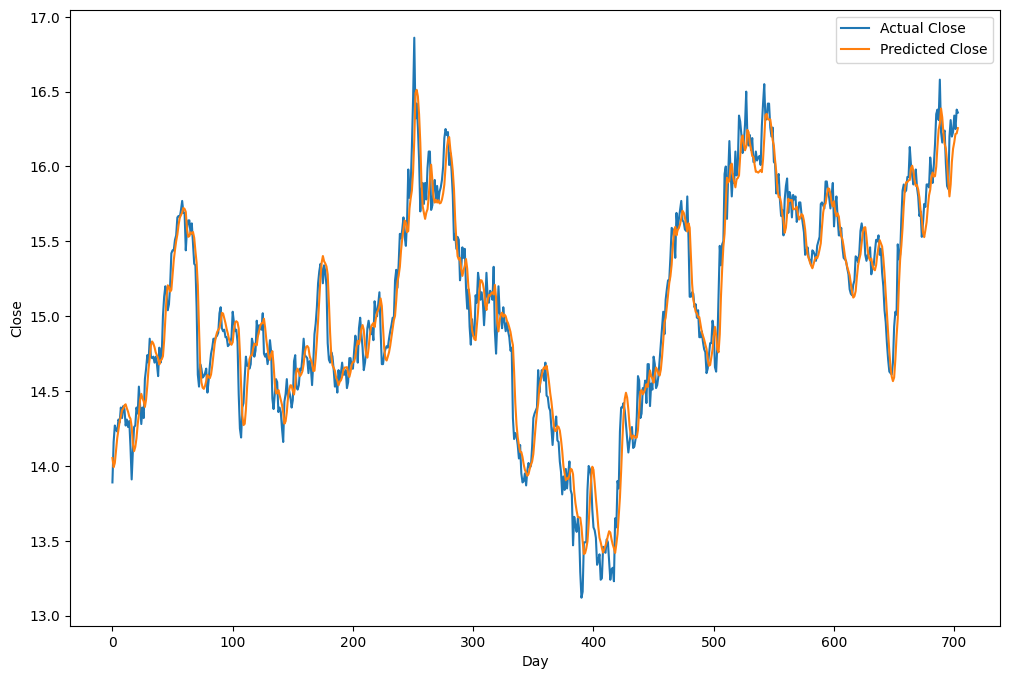

In [22]:
plt.figure(figsize=(12, 8))
plt.plot(new_Y_train, label='Actual Close')
plt.plot(trained_prediction, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


#X_train vs Y_train adjusted

In [23]:
test_predictions = model(X_test).detach().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

#predicted_data

array([16.27375541, 16.37476244, 16.42861736, 16.43714722, 16.41049607,
       16.32457168, 16.26729381, 16.2386114 , 16.18098711, 16.14388897,
       16.09886241, 16.08613628, 16.16003517, 16.2310158 , 16.22058286,
       16.12367312, 16.08699586, 16.09876656, 16.08260966, 16.09042796,
       16.05910661, 16.04848284, 16.05109348, 16.10700395, 16.16476868,
       16.18572508, 16.25143028, 16.25079807, 16.1980348 , 16.17544216,
       16.1615867 , 16.15661912, 16.1251337 , 16.0882246 , 15.97811881,
       15.88279115, 15.86419527, 15.89804633])

In [24]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = Y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_Y_test = dc(dummies[:, 0])
new_Y_test

#actual_data

array([16.62000074, 16.54000093, 16.49999991, 16.45999912, 16.31999979,
       16.36000058, 16.36000058, 16.23999976, 16.25000001, 16.18000024,
       16.20999899, 16.3999996 , 16.38999934, 16.23999976, 16.06999966,
       16.20000074, 16.25000001, 16.14999969, 16.20999899, 16.10000043,
       16.14999969, 16.14999969, 16.28000078, 16.29999928, 16.26000027,
       16.42000011, 16.28000078, 16.20000074, 16.27000052, 16.26000027,
       16.26000027, 16.18000024, 16.14999969, 15.93000033, 15.92000008,
       16.01000014, 16.06999966, 16.18000024])

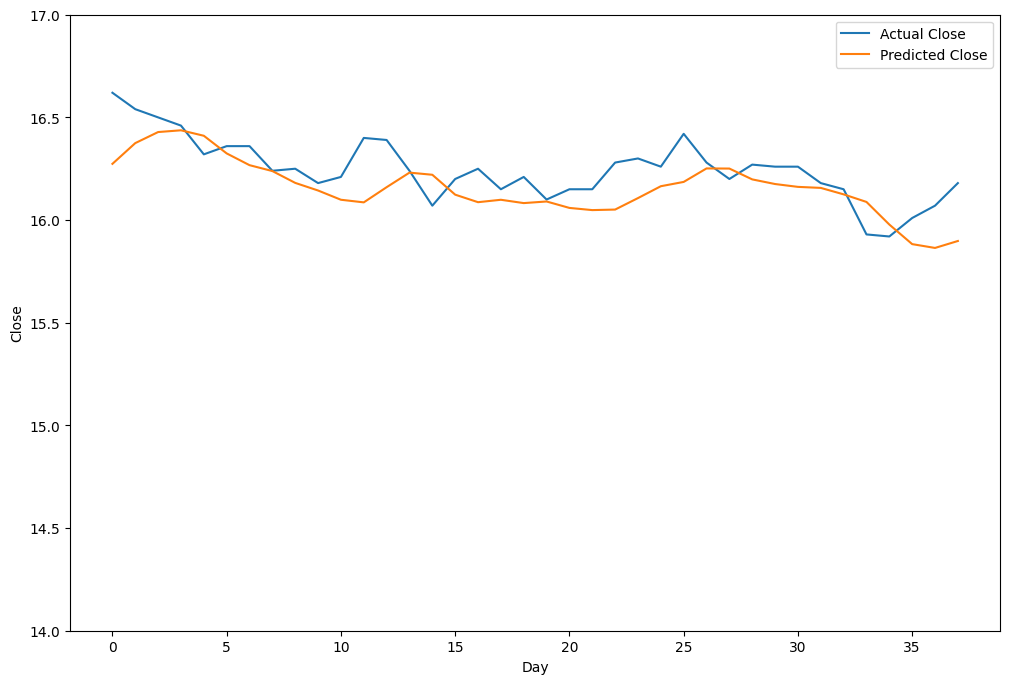

In [25]:
plt.figure(figsize=(12, 8))
plt.plot(new_Y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.ylim(14, 17)
plt.show()


In [26]:
import pandas as pd
Comparsion_data = {"Actual_data; Y_test": new_Y_test, "Predicted_data; X_test":test_predictions, "Difference": new_Y_test - test_predictions}
Comparsion_table = pd.DataFrame(data=Comparsion_data)
Comparsion_table.index = Comparsion_table.index + 1
Comparsion_table

,Actual_data; Y_test,Predicted_data; X_test,Difference
1,16.620001,16.273755,0.346245
2,16.540001,16.374762,0.165238
3,16.500000,16.428617,0.071383
4,16.459999,16.437147,0.022852
5,16.320000,16.410496,-0.090496
6,16.360001,16.324572,0.035429
7,16.360001,16.267294,0.092707
8,16.240000,16.238611,0.001388
9,16.250000,16.180987,0.069013
10,16.180000,16.143889,0.036111
